# **CHEM E 545 Final Project**
## **Predicting Catalyst Deactivation using Multi-Layer Perceptron** <br>
In this final project, you will develop a multi-layer perceptron (MLP) neural network using scikit-learn as well as your own customized deep learning model using tensorflow to predict catalyst deactivation in chemical processes. Catalysts are essential in many chemical engineering operations, but they can lose effectiveness over time due to various mechanisms including poisoning, fouling, sintering, and thermal degradation. Predicting when a catalyst will deactivate is crucial for scheduling maintenance and optimizing process economics.
You have been provided with a .csv file with some attributes about the catalyst and a deactivation state.  Do data preprocessing if necessary at any step, always use a random seed wherever you can and describe your methods and results in detail. All plots should have labels and legends. 
Complete the tasks below (80 points):

In [1]:
# Import necessary libraries

# Data Handling and Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Dimensionality Reduction and Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Evaluation and Validation
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Machine Learning Models
from sklearn.neural_network import MLPClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Tensor Flow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_curve, auc
print("Hi")

Hi


### **1. Data Preprocessing**
check for the presence of categorial variables, decide how will you handle it, handle any missing values and visualize the class distribution.  Split the data into training and testing sets using stratified sampling (used when there are class imbalances) and preprocess your data using standard scaler ( note: categorial features are not processed using standard scaler) (10 points).

#### **Question 1 Discussion: Preliminary thoughts and motivations** 

By looking at the data, there is a mix of both numerical and string values. The target feature, catalyst activation is binary true/false. This makes it a good candidate for binary encoding. The other categorical features are 'Catalyst_Type', 'Operation_Mode', and 'Reactor_Type'. These are best candidates for one-hot-encoding, as integer encoding may impose a relationship within those types that does not exist in the data. At first glance, there are no missing values, although it is still good to check for those.

From visualizing the class distribution of Deactivated True/False values, we can confirm that there is a significant ~1:2 class imbalance. This justifies the use of stratified sampling.

Since the problem description explicitly mentions standard scalar, no other scalars will be considered at this time.

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('catalyst_data.csv')

# Display the first few rows of the DataFrame to verify
print(df.head())

   Temperature   Pressure      WHSV  Feed_Impurity  Residence_Time   
0   312.362036  10.071514  2.986204       3.363515        2.902780  \
1   485.214292  27.553146  2.846299       3.983407        4.046618   
2   419.598183  43.774346  9.109419       1.252339        3.824789   
3   379.597545  36.879019  2.870689       3.124370        0.854110   
4   246.805592  40.521496  3.083522       2.858730        0.831322   

  Catalyst_Type  Catalyst_Age  Surface_Area  Pore_Volume  Active_Sites   
0   Noble Metal    628.347118    336.941412     1.356101      4.461899  \
1   Noble Metal    184.101323    557.827052     0.269051      2.451757   
2   Noble Metal    105.650345    453.482966     1.318636      2.354421   
3   Metal Oxide    812.850972    377.375009     1.600180      0.660255   
4   Noble Metal    578.756476    697.161703     1.100645      2.740893   

   Regeneration_Cycles Operation_Mode Reactor_Type  Deactivated  
0                    1          Batch    Fixed Bed        False  
1 

In [3]:
# Check for categorical variables
print("Categorical Variables:")
print(df.select_dtypes(include=['object', 'bool']).columns)

# Handle categorical variables
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=["Catalyst_Type", "Operation_Mode", "Reactor_Type"], drop_first=True)

# Map 'Deactivated' to binary (True -> 1, False -> 0)
df["Deactivated"] = df["Deactivated"].astype(int)


Categorical Variables:
Index(['Catalyst_Type', 'Operation_Mode', 'Reactor_Type', 'Deactivated'], dtype='object')


In [4]:
# Handle missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Temperature                   0
Pressure                      0
WHSV                          0
Feed_Impurity                 0
Residence_Time                0
Catalyst_Age                  0
Surface_Area                  0
Pore_Volume                   0
Active_Sites                  0
Regeneration_Cycles           0
Deactivated                   0
Catalyst_Type_Noble Metal     0
Catalyst_Type_Zeolite         0
Operation_Mode_Continuous     0
Operation_Mode_Semi-batch     0
Reactor_Type_Fluidized Bed    0
Reactor_Type_Trickle Bed      0
dtype: int64


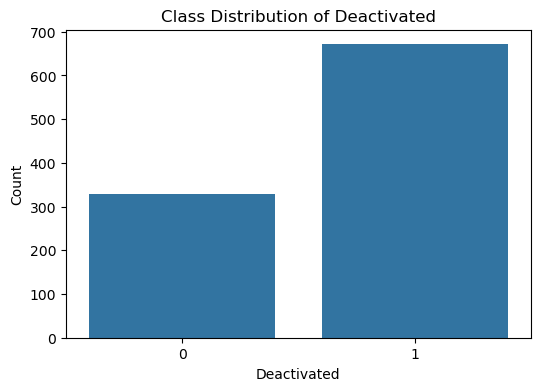

In [5]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="Deactivated", data=df)
plt.title("Class Distribution of Deactivated")
plt.xlabel("Deactivated")
plt.ylabel("Count")
plt.show()

In [6]:
# Split the data into training and testing sets using stratified sampling
X = df.drop("Deactivated", axis=1)  # Features
y = df["Deactivated"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Preprocess data using StandardScaler (only for numerical features)
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

### **2. Data Visualization and Unsupervised Classification**
Visualize the data and implement PCA (justify the choice of the optimal number of components) and K-means to see if you can separate different states. Finally, try doing K-means to see if you get better clustering. Report your findings. (10)

### **Question 2 Discussion**

The simplest and most comprehensive overview of this type of data is done with a pair-plot color-coded by activation status. From the diagonals, we notice the class distribution again, as well as a curious bimodal distribution for some of the values, notably pressure and residence time. From the pairplot, it is clear that no one specific variable or combination of 2 variables is sufficient in predicting the activation status (i.e. there are significant/noticeble patterns within the pair plots). See PCA Discussion below.

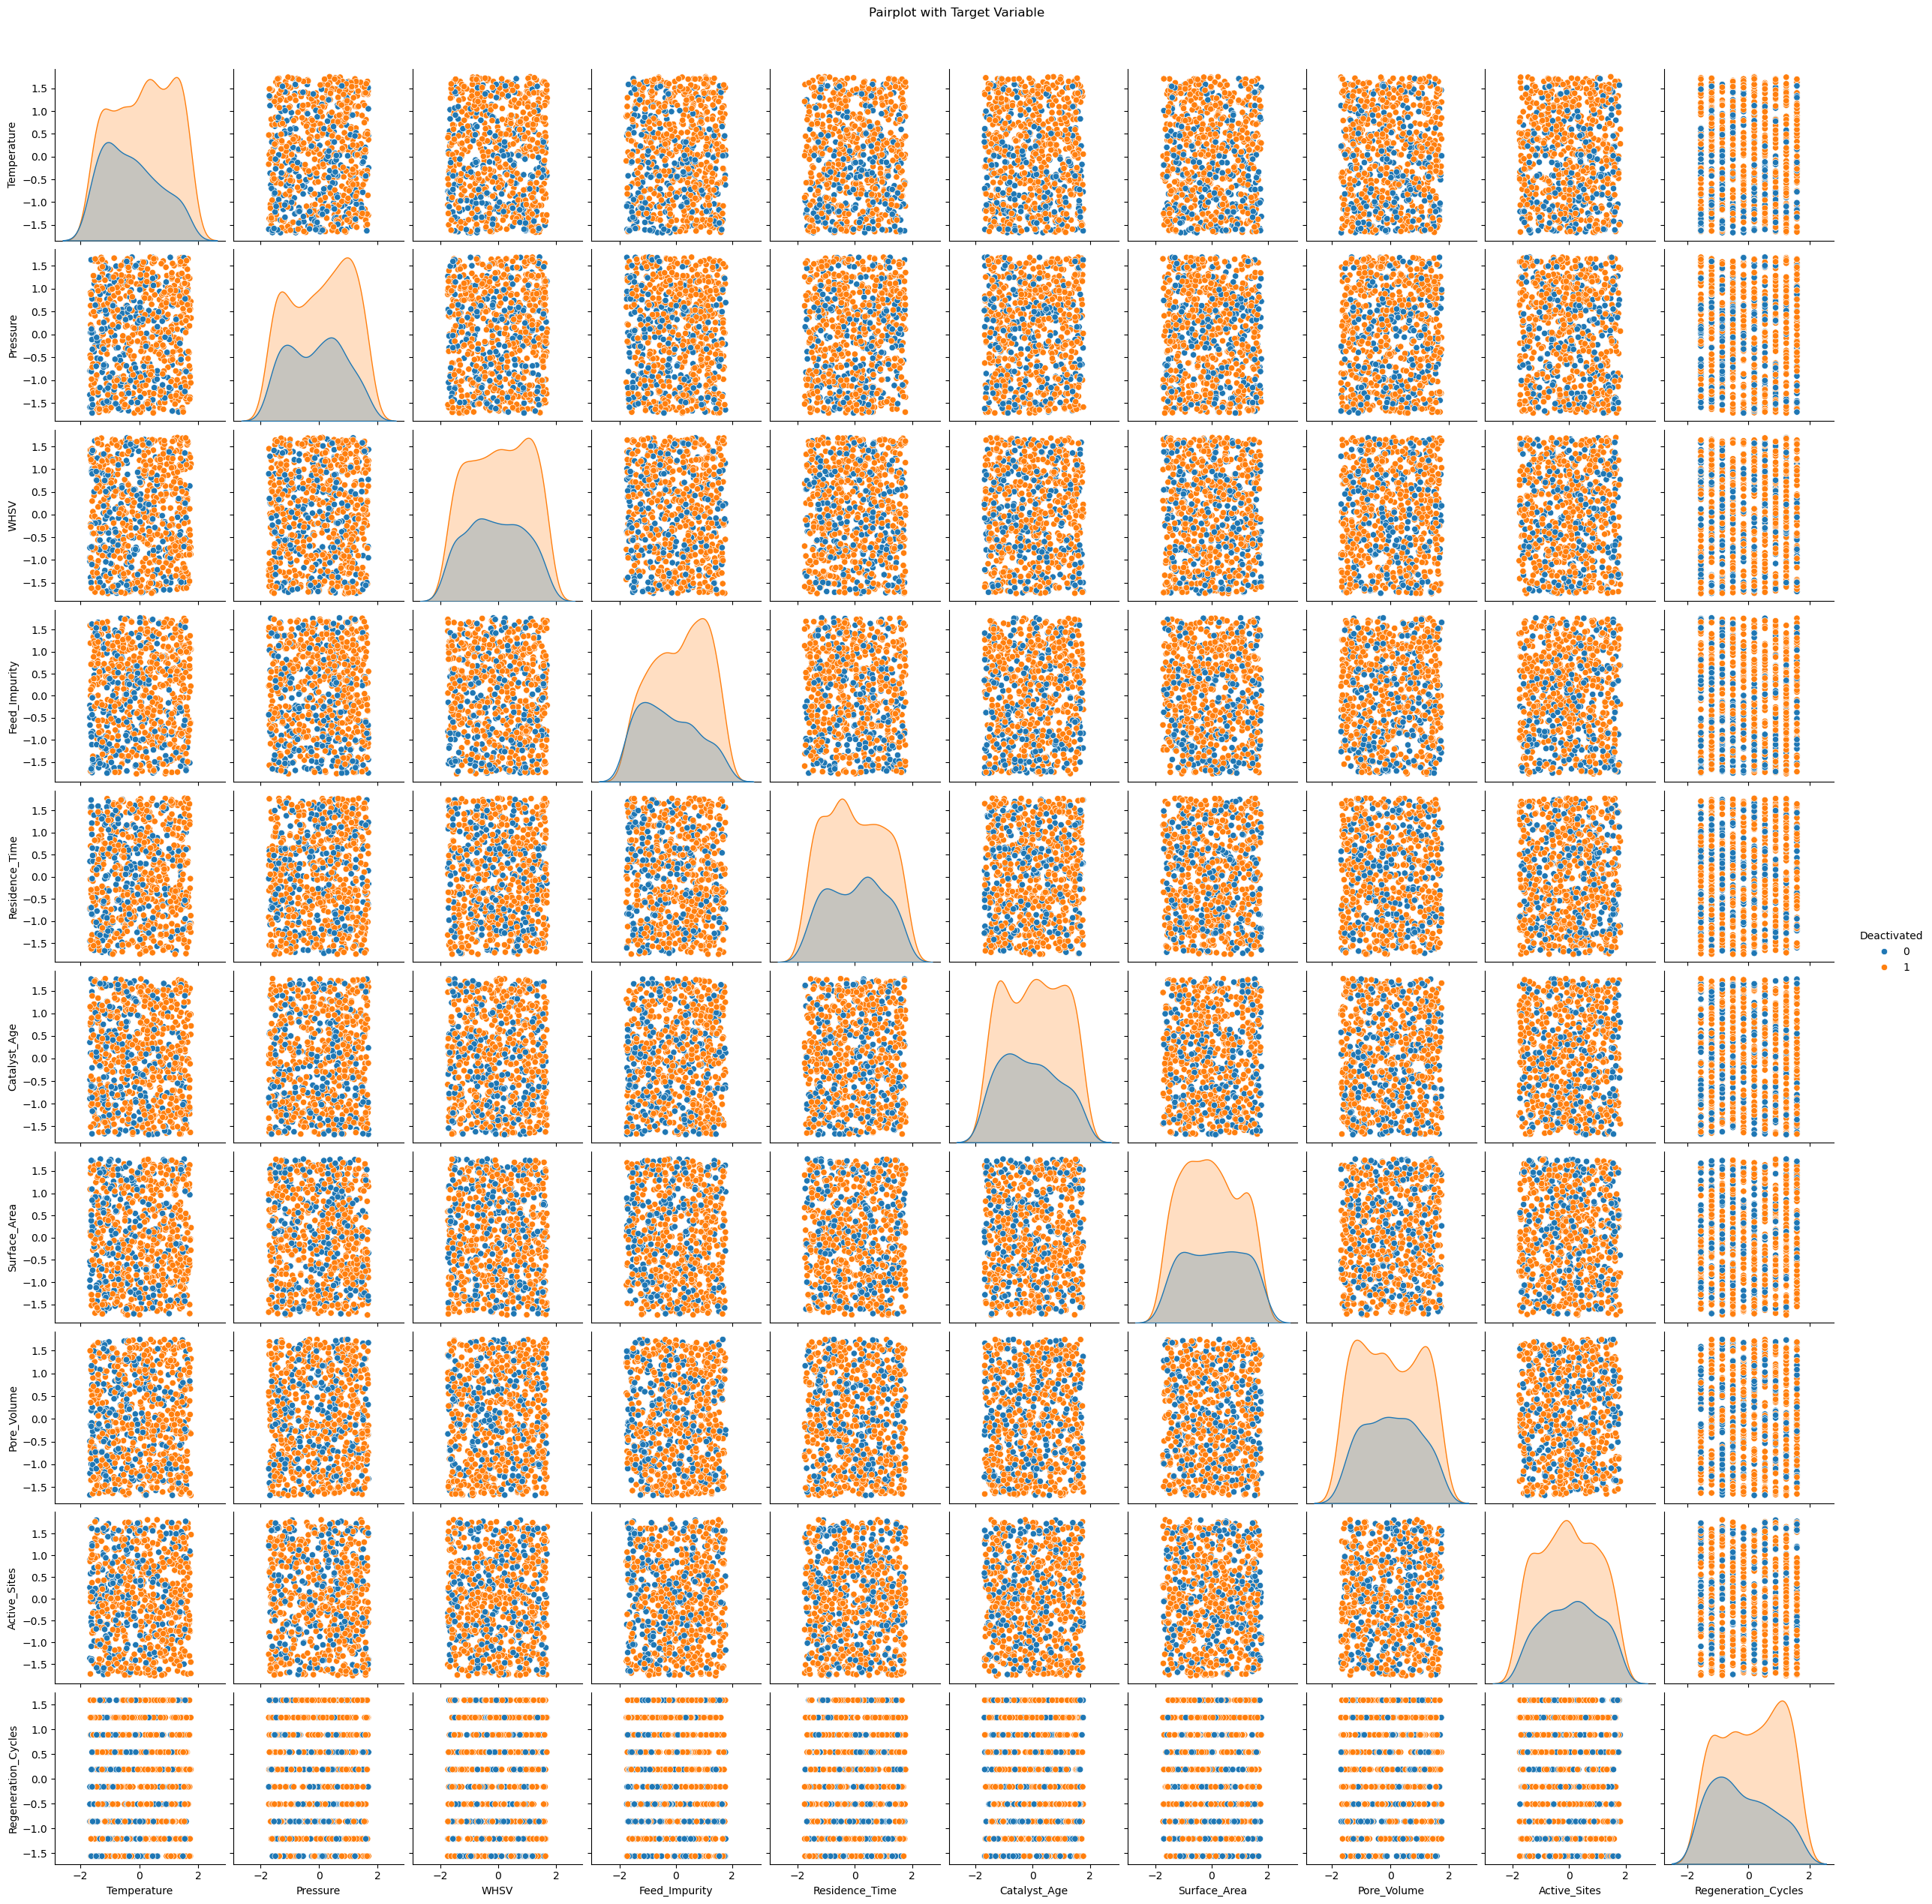

In [8]:
# Add the target variable to the DataFrame
X_train_with_target = X_train.copy()
X_train_with_target["Deactivated"] = y_train

# Create a pairplot with the target variable
sns.pairplot(X_train_with_target, hue="Deactivated", vars=numerical_features)
plt.suptitle("Pairplot with Target Variable", y=1.02)
plt.show()

### **PCA Discussion**

Since PCA is not typically done on categorical variables, this leaves 10 total variables to consider. The variance by components plot shows a near linear fit, which does not allow for effecitve use of the elbow method to determine the optimal number of components. Therefore, we go with the rule of thumb to cover 80% variance, in this case with 8 components. Note that some plots represent PCA with 2 components (for visual clarity).

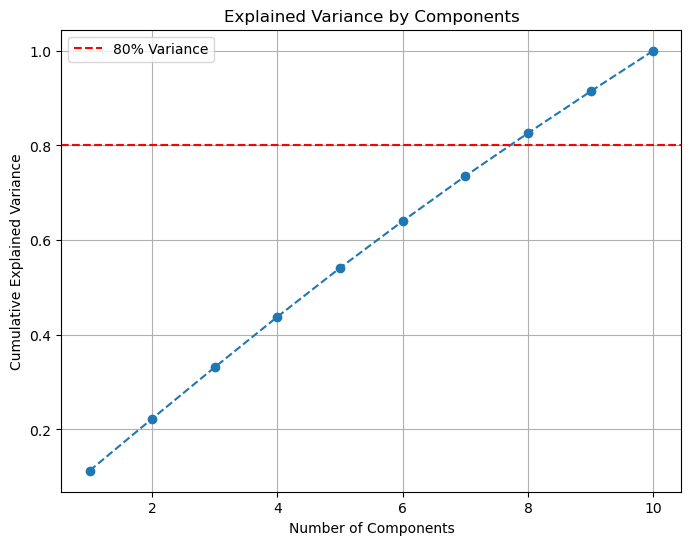

Number of components needed to explain 80% of variance: 8
-----------------------------------------------------------------


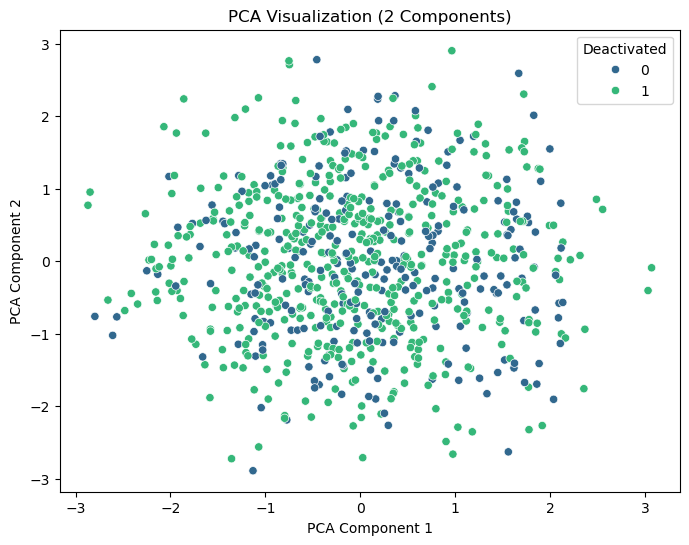

In [9]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_train[numerical_features])

# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Variance')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title('Explained Variance by Components')
plt.legend()
plt.grid(True)
plt.show()

# Choose number of components that explain 80% of variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.80) + 1
print(f"Number of components needed to explain 80% of variance: {n_components}")
print("-"*65)

# 2 components only for visualization
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_train[numerical_features])

# 8 components as the optimal number
pca_8 = PCA(n_components=8)
X_train_pca_8 = pca_8.fit_transform(X_train[numerical_features])

# Visualize PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=y_train, palette='viridis')
plt.title(f"PCA Visualization (2 Components)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Deactivated")
plt.show()



In [10]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()
print(f"Explained variance with 2 components: {cumulative_variance[1]:.2f}")
print(f"Explained variance with 8 components: {cumulative_variance[7]:.2f}")

Explained variance with 2 components: 0.22
Explained variance with 8 components: 0.83


PCA Loadings (Contributions of Original Features to PC1 and PC2):
     Temperature  Pressure      WHSV  Feed_Impurity  Residence_Time   
PC1    -0.493602 -0.596630 -0.121885       0.264928       -0.454148  \
PC2    -0.148100 -0.054722 -0.092863      -0.280460        0.147061   

     Catalyst_Age  Surface_Area  Pore_Volume  Active_Sites   
PC1      0.084289      0.256349    -0.099263      0.162411  \
PC2      0.175700      0.380803    -0.029212     -0.535523   

     Regeneration_Cycles  
PC1            -0.006829  
PC2             0.634542  


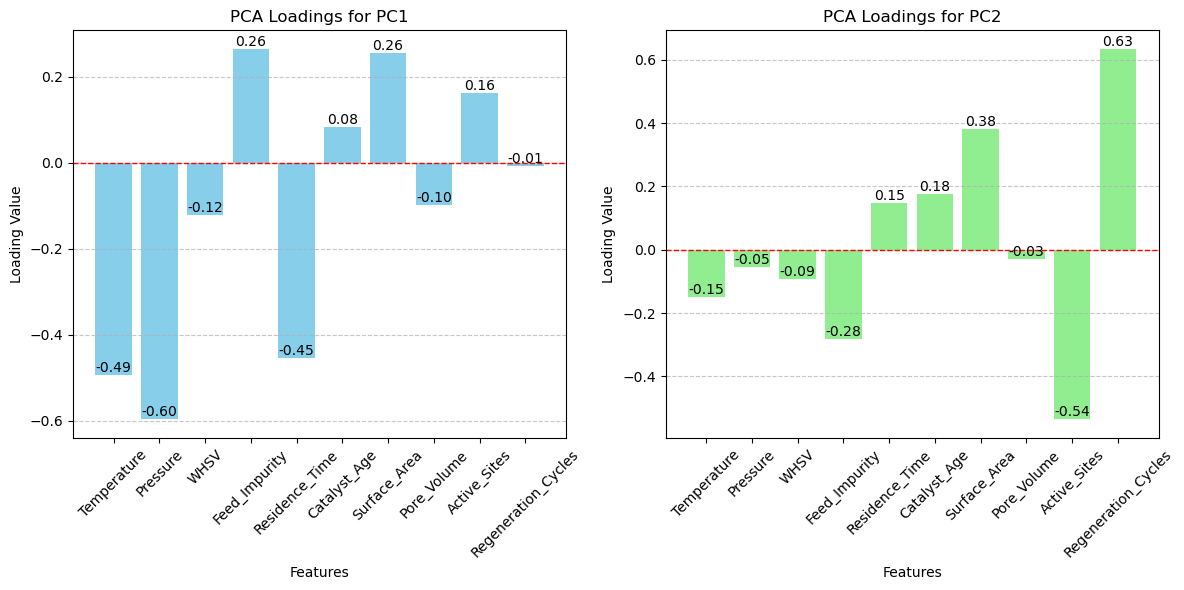

In [11]:
# See how much each feature contributes when 2 components are used

# Get the PCA loadings (components_ attribute)
pca_2_loadings = pca_2.components_

# Create a DataFrame to show the contribution of each original feature to the PCA components
loadings_2_df = pd.DataFrame(pca_2_loadings, columns=numerical_features, index=['PC1', 'PC2'])

# Display the loadings
print("PCA Loadings (Contributions of Original Features to PC1 and PC2):")
print(loadings_2_df)

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot the loadings for PC1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
bars = plt.bar(loadings_2_df.columns, loadings_2_df.loc['PC1'], color='skyblue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a reference line at 0
plt.title("PCA Loadings for PC1")
plt.xlabel("Features")
plt.ylabel("Loading Value")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Plot the loadings for PC2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
bars = plt.bar(loadings_2_df.columns, loadings_2_df.loc['PC2'], color='lightgreen')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a reference line at 0
plt.title("PCA Loadings for PC2")
plt.xlabel("Features")
plt.ylabel("Loading Value")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

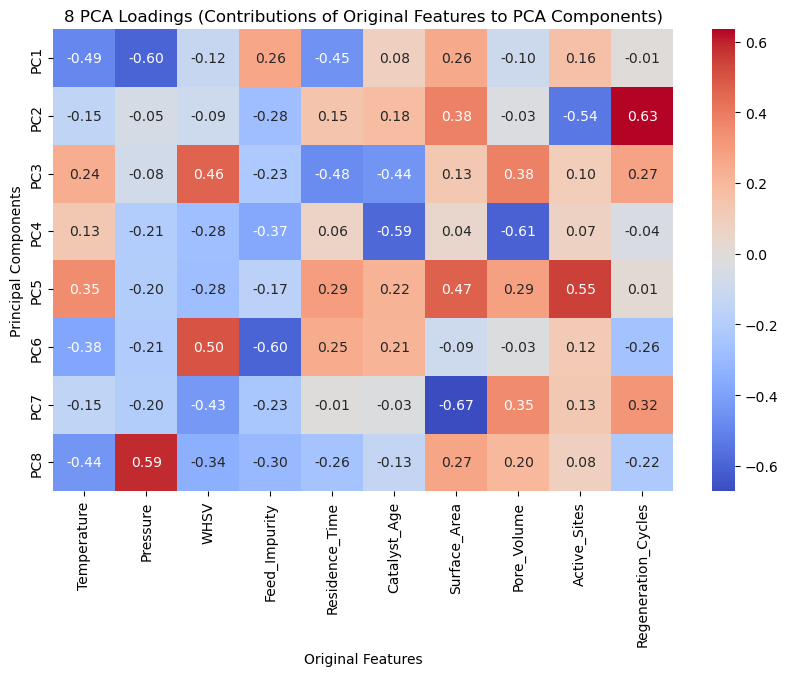

In [12]:
# See how much each feature contributes when 8 components are used

# Get PCA loadings for PCA = 8 (components_ attribute)
loadings = pca_8.components_

# Create a heatmap of PCA loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=numerical_features, yticklabels=[f'PC{i+1}' for i in range(8)])
plt.title("8 PCA Loadings (Contributions of Original Features to PCA Components)")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()

### **K-Means Clustering Discussion**




We applied **K-Means clustering** to uncover potential structure in the catalyst dataset using an unsupervised learning approach. This allowed us to explore patterns in the data **without using any label information**, offering an unbiased look at how the samples naturally group.

To reduce dimensionality and improve clustering performance, we first applied **PCA**. We used **n=8** based on the previous **explained variance curve**. This helped retain the most important variance in the data while making the clusters easier to visualize in 2D space.

Initially, we experimented with **K = 2**, assuming a binary division might correspond to catalyst activation status. However, after reflecting on the nature of unsupervised learning, we decided to let the data guide the optimal number of clusters rather than aligning directly with known labels.

We used the **elbow method** to evaluate the optimal value for **K**. While the elbow in the WCSS plot was not sharply defined, we observed a subtle inflection around **K = 4**, which we selected for our final clustering. 

Upon plotting the K-Means results with **K = 4**, we saw distinguishable clusters with some overlap, indicating that the data has **underlying subgroups** beyond just active vs. deactivated labels. Although these clusters do not align perfectly with known classes, they suggest that the features used in our dataset contain richer structure, possibly tied to different catalyst types, mechanisms, or degradation pathways.

**Choosing the Number of PCA Components for K-Means**  

This plot shows how K-Means clustering looks when using different numbers of PCA components (**n = 2 to 10**). While **n = 2** may seem to give the best separation in 2D, it doesn’t mean it’s the best overall. Higher **n** might give better clustering, but we can’t see it clearly because it happens in more dimensions.  

To decide the best **n**, we looked at the **explained variance plot**. Since **n = 8** captures more than **80% of the variance**, we chose it for our final clustering.  


In [13]:
# 8 components as the optimal number, do kmeans on the transformed PCA 
pca_8 = PCA(n_components=8)
X_train_pca_8 = pca_8.fit_transform(X_train[numerical_features])
X_test_pca_8 = pca_8.transform(X_test[numerical_features])

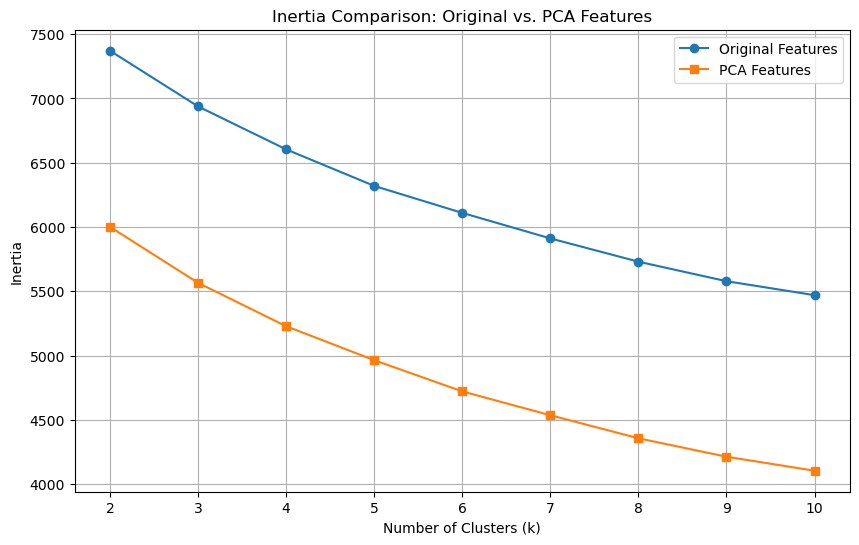

In [14]:
# First K-means on original features
# Calaulate inertia for each K on original features
K_range = range(2, 11)
inertia_original = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train[numerical_features])
    inertia_original.append(kmeans.inertia_)

# Second K-means on PCA-transformed features
# Calaulate inertia for each K on PCA features
inertia_pca = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca_8)
    inertia_pca.append(kmeans.inertia_)

# Plot inertia comparison
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia_original, marker='o', label='Original Features')
plt.plot(K_range, inertia_pca, marker='s', label='PCA Features')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia Comparison: Original vs. PCA Features')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers (PCA-reduced space): 
[[ 0.25771153  1.08349479  0.38923057 -0.16512799  0.08887757 -0.36164388
   0.14075757 -0.13033627]
 [ 1.0957796  -0.75331887 -0.11478634  0.0679549   0.27616857  0.16085165
  -0.22027211  0.05942105]
 [-0.74758543 -0.47101217  0.76840603 -0.04500989 -0.46692441  0.21347392
  -0.16270831 -0.16230077]
 [-0.57905573 -0.03339613 -1.10227389  0.16694195  0.10701435  0.04056392
   0.21386085  0.25370027]]


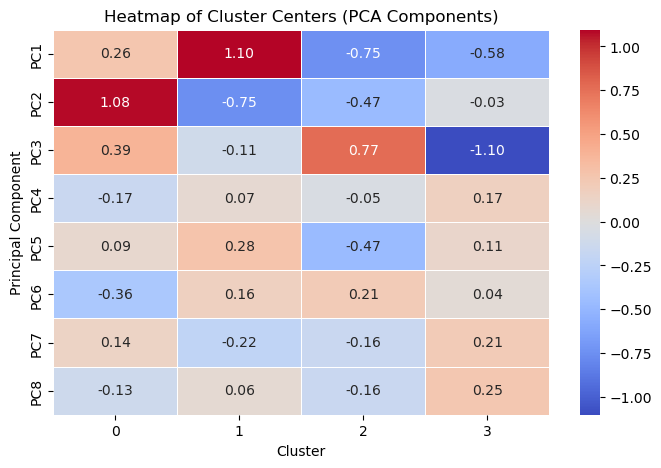

In [15]:
# Apply K-Means with the best K (from elbow method)
best_k = 4  # based on elbow, 4 clusters is best
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_pca_8)

# Analyze Clustering Results
print(f"Cluster Centers (PCA-reduced space): \n{kmeans.cluster_centers_}")
# Then I realized this makes no sense to me, how do i visualize 4 clusters in 8 dimensions? lets try a heatmap

# Create a DataFrame of Cluster Centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(8)])

# Plot Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(cluster_centers.T, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel("Cluster")
plt.ylabel("Principal Component")
plt.title("Heatmap of Cluster Centers (PCA Components)")
plt.show()

c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


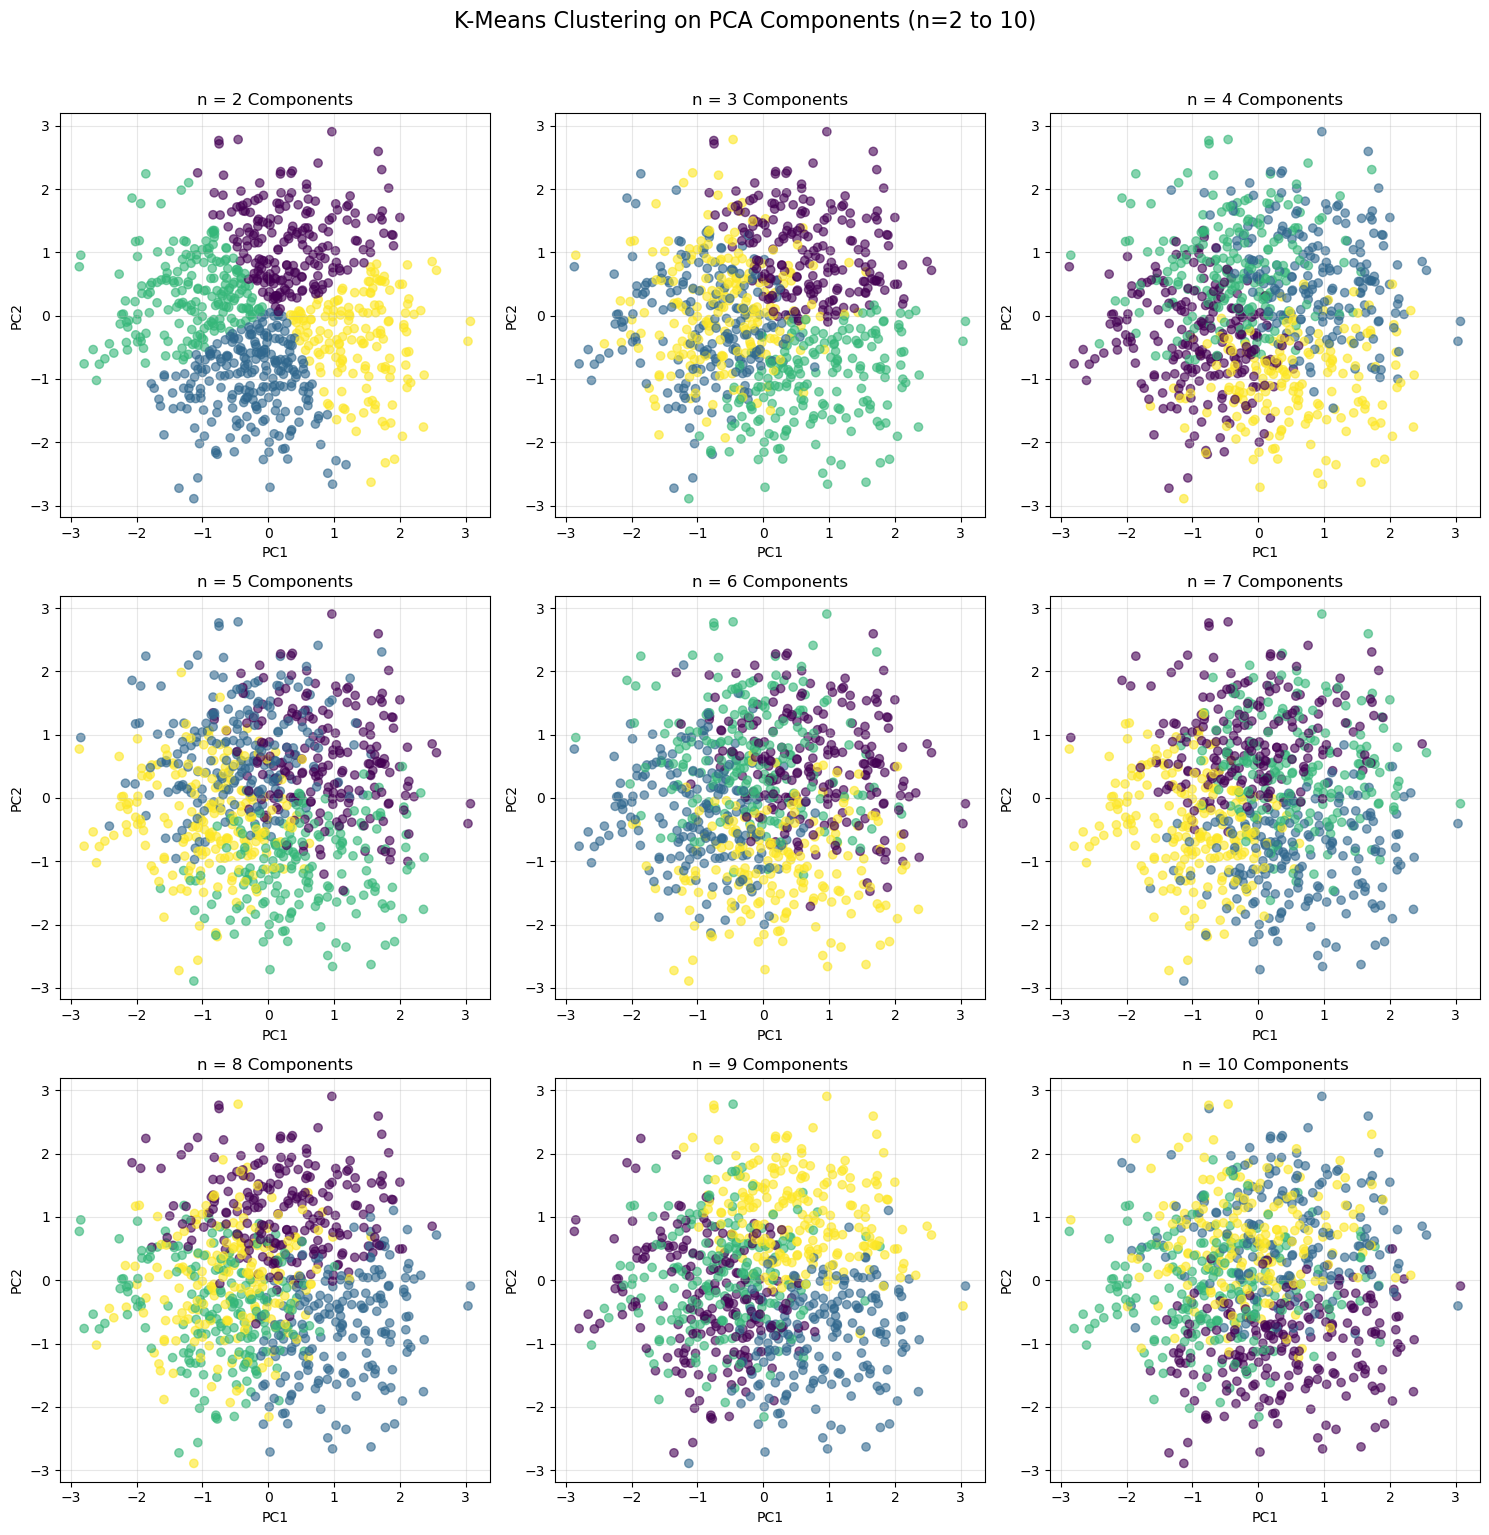

In [16]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("K-Means Clustering on PCA Components (n=2 to 10)", y=1.02, fontsize=16)

# Loop through n=2 to 10
for n in range(2, 11):
    # Perform PCA with n components
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_train[numerical_features])
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    clusters = kmeans.fit_predict(X_pca)
    
    # Determine the subplot position
    row = (n - 2) // 3
    col = (n - 2) % 3
    ax = axes[row, col]
    
    # Plot the clusters using the first 2 PCA components
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    ax.set_title(f"n = {n} Components")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    
    # Add grid for better visualization
    ax.grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

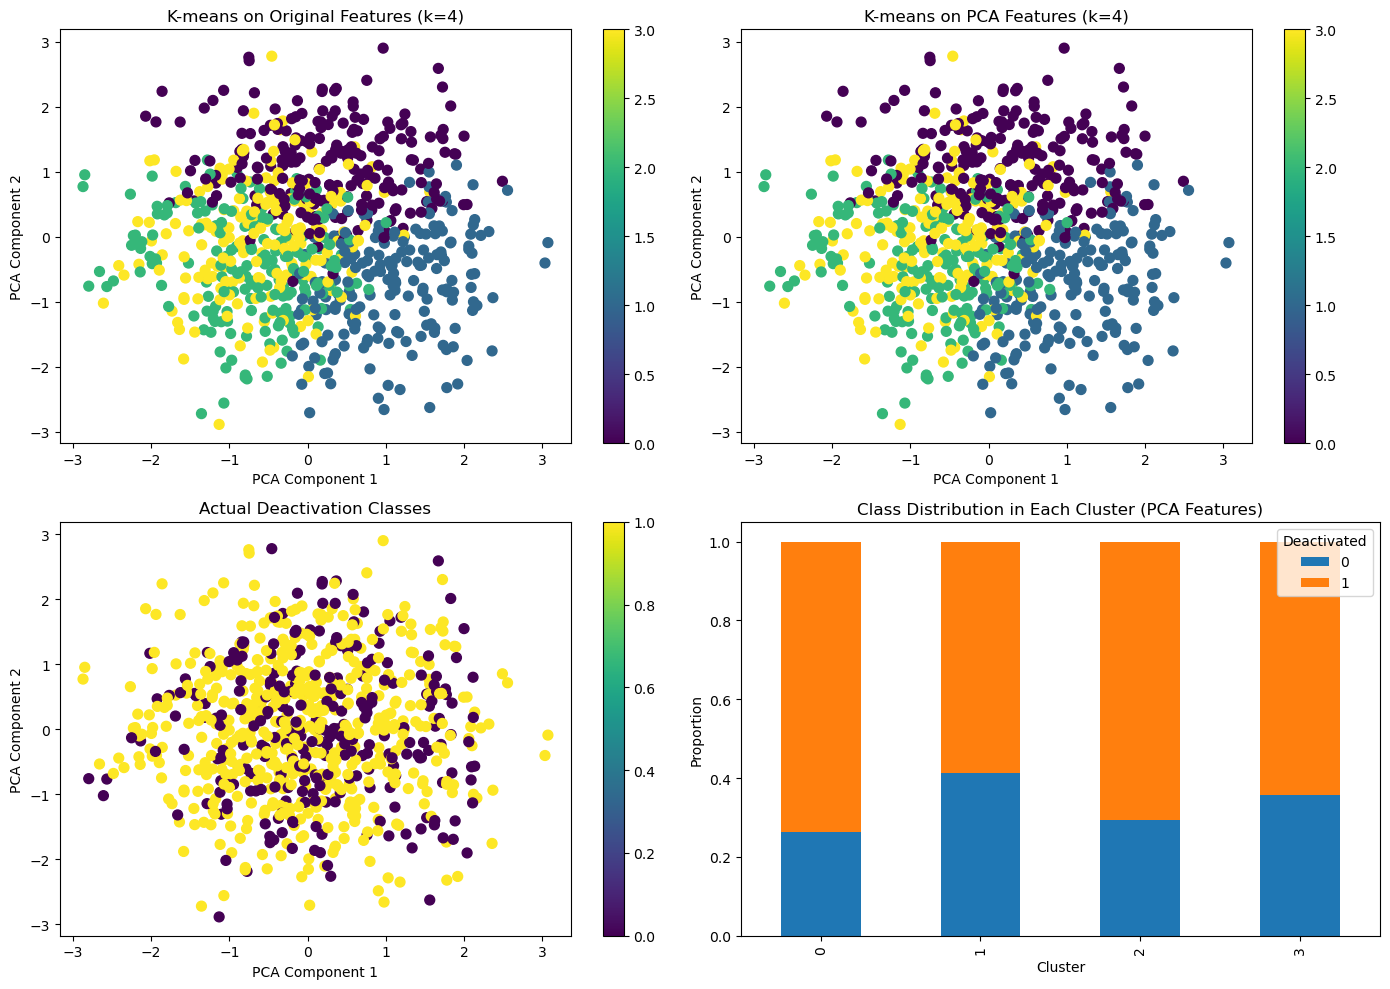


Summary of Findings:
- PCA required 8 components to explain 80% of variance
- Optimal number of clusters: 4 for original features, 4 for PCA features


In [17]:
# Apply K-means with optimal K on PCA features
kmeans_pca = KMeans(n_clusters=4, random_state=42, n_init=10)
train_clusters_pca = kmeans_pca.fit_predict(X_train_pca_8)
test_clusters_pca = kmeans_pca.predict(X_test_pca_8)


# Visualize clusters vs. actual classes
if n_components >= 2:
    # Create a figure with 2x2 subplots
    plt.figure(figsize=(14, 10))
    
    # Plot 1: K-means clusters on original features
    # We'll use the first 2 PCA components just for visualization
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(X_train_pca_8[:, 0], X_train_pca_8[:, 1], c=train_clusters_pca, cmap='viridis', s=50)
    plt.title(f'K-means on Original Features (k={4})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter)
    
    # Plot 2: K-means clusters on PCA features
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(X_train_pca_8[:, 0], X_train_pca_8[:, 1], c=train_clusters_pca, cmap='viridis', s=50)
    plt.title(f'K-means on PCA Features (k={4})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter)
    
    # Plot 3: Actual classes
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(X_train_pca_8[:, 0], X_train_pca_8[:, 1], c=y_train, cmap='viridis', s=50)
    plt.title('Actual Deactivation Classes')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter)
    
    # Plot 4: Distribution of actual classes within clusters
    plt.subplot(2, 2, 4)
    best_clusters = train_clusters_pca
    cluster_type = "PCA Features"
    n_clusters = 4
    
    # Count deactivated catalysts in each cluster
    cluster_counts = pd.DataFrame({
        'Cluster': best_clusters,
        'Deactivated': y_train.reset_index(drop=True)
    }).groupby('Cluster')['Deactivated'].value_counts(normalize=True).unstack().fillna(0)
    
    # Plot as stacked bar chart
    cluster_counts.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Class Distribution in Each Cluster ({cluster_type})')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.legend(title='Deactivated')
    
    plt.tight_layout()
    plt.show()

# Summary of findings
print(f"\nSummary of Findings:")
print(f"- PCA required {n_components} components to explain 80% of variance")
print(f"- Optimal number of clusters: 4 for original features, 4 for PCA features")

#### **K-Means Clustering on Original vs. PCA-Reduced Features**  

This figure compares K-Means clustering results on the **original features** (top-left) and **PCA-reduced features** (top-right) using **K = 4**, along with the actual deactivation classes (bottom-left) and the cluster-wise class distribution (bottom-right).  

- The clustering results look similar for both the **original** and **PCA-reduced** features, suggesting that PCA retained key information while reducing dimensionality.  
- The bottom-left plot shows the true deactivation classes, which do not fully align with any single cluster.  
- The bar chart (bottom-right) shows the **class distribution within each cluster**, indicating that no single cluster contains only active or deactivated catalysts.  

While K-Means provides some separation, it does not perfectly distinguish catalyst deactivation. This supports the need for **supervised learning methods** in later steps.  

### **3. Classification of materials**
Implement a MLP classifier on the data and estimate the accuracies, F-1 score and confusion matrix. Also carry out 5 fold stratified cross validation(read and explain this) and report the mean F1 score. (20)

### MLP Classifier

Accuracy: 0.6700
F1 Score: 0.7609
Confusion Matrix:
[[ 29  37]
 [ 29 105]]


c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


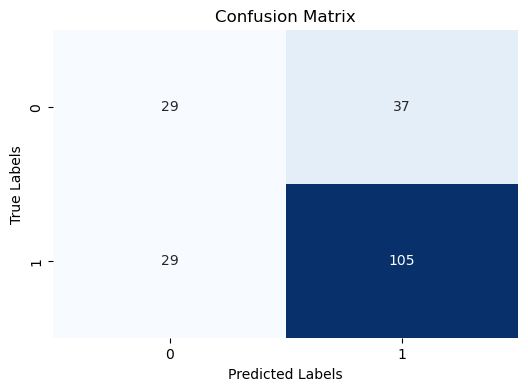


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.44      0.47        66
           1       0.74      0.78      0.76       134

    accuracy                           0.67       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.66      0.67      0.66       200



c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



F1 Scores for 5-Fold Stratified Cross-Validation:
[0.7699115  0.77586207 0.75892857 0.81385281 0.76444444]
Mean F1 Score: 0.7766


c:\Users\Junyi\anaconda3\envs\cheme545\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
# Transform the data
X_train_pca = pca.transform(X_train[numerical_features])
X_test_pca = pca.transform(X_test[numerical_features])
# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Train the model on the PCA-transformed training data
mlp.fit(X_train_pca, y_train)

# Evaluate the Model
# Predict on the test set
y_pred = mlp.predict(X_test_pca)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Perform 5-Fold Stratified Cross-Validation
# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate F1 scores
f1_scores = cross_val_score(mlp, X_train_pca, y_train, cv=stratified_kfold, scoring='f1')

# Print the F1 scores for each fold and the mean F1 score
print("\nF1 Scores for 5-Fold Stratified Cross-Validation:")
print(f1_scores)
print(f"Mean F1 Score: {f1_scores.mean():.4f}")

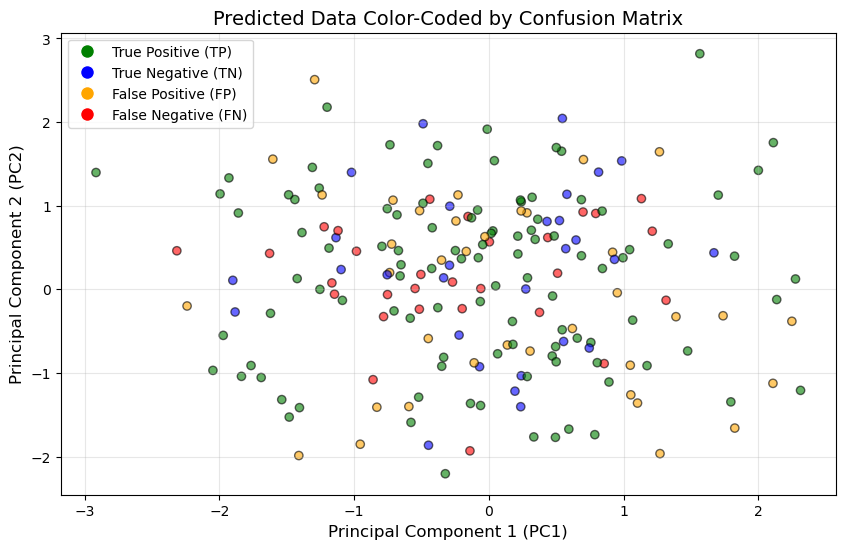

In [19]:
# Create an array to store the color for each point
colors = np.empty(len(y_test), dtype=object)  # Use dtype=object to store strings

# Assign colors based on the confusion matrix
for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)):
    if true_label == 1 and pred_label == 1:  # True Positive (TP)
        colors[i] = 'green'  # Correctly predicted as positive
    elif true_label == 0 and pred_label == 0:  # True Negative (TN)
        colors[i] = 'blue'  # Correctly predicted as negative
    elif true_label == 0 and pred_label == 1:  # False Positive (FP)
        colors[i] = 'orange'  # Incorrectly predicted as positive
    elif true_label == 1 and pred_label == 0:  # False Negative (FN)
        colors[i] = 'red'  # Incorrectly predicted as negative

# Plot the PCA-transformed data with color coding
plt.figure(figsize=(10, 6))

# Scatter plot of the first two PCA components
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=colors, alpha=0.6, edgecolor='k')

# Add labels and title
plt.title("Predicted Data Color-Coded by Confusion Matrix", fontsize=14)
plt.xlabel("Principal Component 1 (PC1)", fontsize=12)
plt.ylabel("Principal Component 2 (PC2)", fontsize=12)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='True Positive (TP)', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='True Negative (TN)', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='False Positive (FP)', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='False Negative (FN)', markerfacecolor='red', markersize=10)
]
plt.legend(handles=legend_elements, loc='best')

# Show the plot
plt.grid(alpha=0.3)
plt.show()

### **4. Hyper-parameter tuning**
Implement hyperparameter tuning with 3fold cross validation on hidden layer sizes (includes both number of hidden layers and neurons), activation function, alpha (regularization) and the learning rate. Report the best performing model and the respective hyperparameters with highest accuracy. Retrain with the best model and report the F1 score on the test set.  (20)

In [20]:
# Define the hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Number of layers and neurons
    'activation': ['relu', 'tanh', 'logistic'],  # Activation function
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'learning_rate_init': [0.001, 0.01, 0.1]  # Initial learning rate
}

# Perform Grid Search with 3-fold cross-validation
mlp = MLPClassifier(max_iter=5000, random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='f1', n_jobs=-1)  # Use F1 score for evaluation
grid_search.fit(X_train_pca, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Retrain and evaluate the best model
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test_pca)

# Calculate F1 score on the test set
f1 = f1_score(y_test, y_pred)
print(f"F1 Score on Test Set: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Hyperparameters:
{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001}
F1 Score on Test Set: 0.7458
Confusion Matrix:
[[ 15  51]
 [ 24 110]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.23      0.29        66
           1       0.68      0.82      0.75       134

    accuracy                           0.62       200
   macro avg       0.53      0.52      0.52       200
weighted avg       0.58      0.62      0.59       200



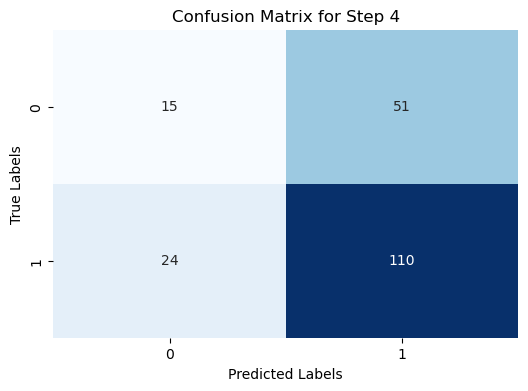

In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Step 4")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

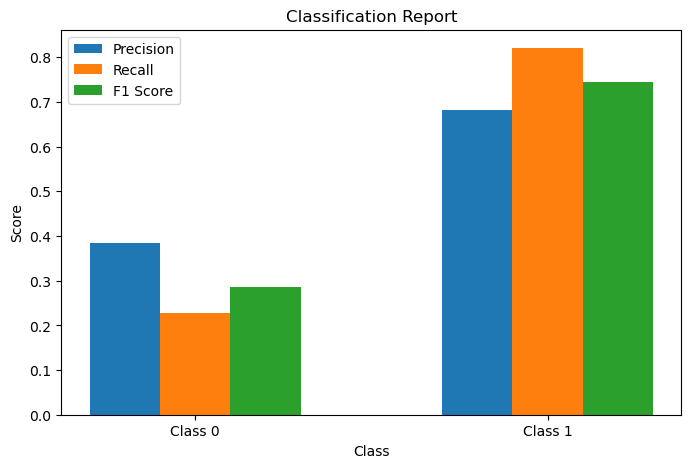

In [22]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
labels = ['Class 0', 'Class 1']  # Replace with your class labels

# Plot the metrics
plt.figure(figsize=(8, 5))
x = np.arange(len(labels))
width = 0.2

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.title("Classification Report")
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(x, labels)
plt.legend()
plt.show()

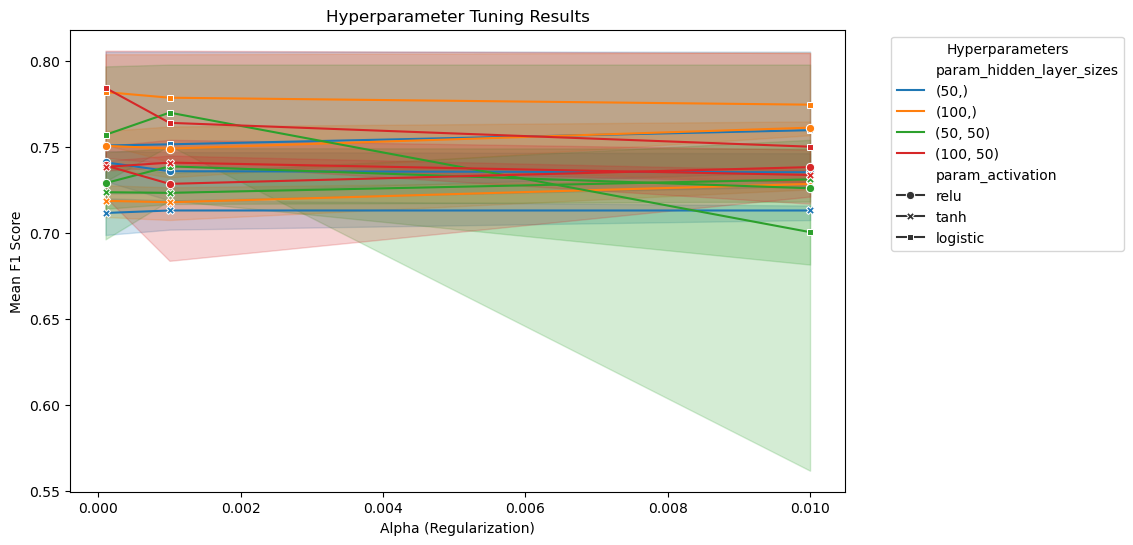

In [23]:
# Convert the grid search results to a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot the performance of different hyperparameter combinations
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_alpha', y='mean_test_score', hue='param_hidden_layer_sizes', style='param_activation', markers=True, dashes=False)
plt.title("Hyperparameter Tuning Results")
plt.xlabel("Alpha (Regularization)")
plt.ylabel("Mean F1 Score")
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

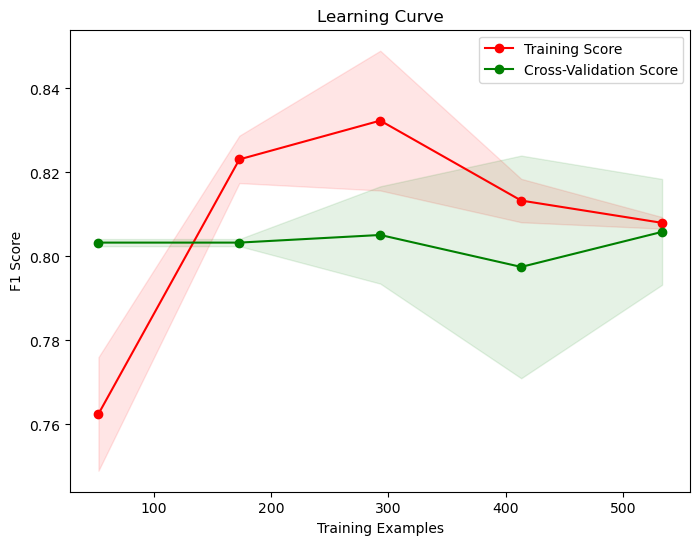

In [24]:
# Get the learning curve data
train_sizes, train_scores, test_scores = learning_curve(best_mlp, X_train_pca, y_train, cv=3, scoring='f1', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

### **5. Neural Networks using Tensorlow**
In the era of generative AI, which is powered by neural networks, many architectures are becoming available to achieve higher accuracy. Implement a neural network in tensorflow using an architecture of your choice (describe the choice). Report the resulting accuracy and F1 score you get on the test set. (20)

#### **Neural Networks using TensorFlow Discussion**

We built a **Neural Network Classifier** to predict catalyst deactivation. The model was designed to match our **PCA-reduced dataset** without adding unnecessary complexity.

#### **Model Design & Choices**
- **Input:** 8 PCA components.
- **Hidden Layers:** Two layers with **64 and 32 neurons**.
  - Chosen because the dataset was **already simplified** using PCA.
- **Activation Functions:**
  - **ReLU** in hidden layers to introduce **non-linearity**.
  - **Sigmoid** in the output layer to give **probabilities (0 to 1) for binary classification**.
- **Loss Function:** Binary Cross-Entropy (best for yes/no predictions).
- **Optimizer:** Adam (adjusts learning rate for better training).

#### **Training & Performance**
- **Trained for 50 epochs** with a **batch size of 32**.
- **Accuracy:** **63.50%**, **F1 Score:** **73.84%**.
- **Confusion Matrix:** The model performs well with **identifying activated catalysts** but struggled with **identifying deactivated catalysts**.
- **ROC-AUC Score:** **0.68**, meaning the model has **some predictive power but isn’t very confident**.

#### **Key Observations**
- **Overfitting:** Training accuracy kept increasing, but **validation accuracy stayed low**.
- **Struggles with Class 0 (Inactive catalysts)**: Many were misclassified.
- **Why This Architecture?**
  - **Two hidden layers** were enough since PCA already reduced the dataset.
  - **ReLU helps the model learn patterns,** while **sigmoid makes predictions easy to interpret**.


This experiment shows that neural networks can classify catalysts but need further tuning for better results.


In [25]:
# Build the Neural Network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train_pca, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the Model
# Predict on the test set
y_pred_prob = model.predict(X_test_pca)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Epoch 1/50
20/20 [==============================] - 1s 18ms/step - loss: 0.6279 - accuracy: 0.6812 - val_loss: 0.6452 - val_accuracy: 0.6313
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 0.5890 - accuracy: 0.6859 - val_loss: 0.6287 - val_accuracy: 0.6438
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5724 - accuracy: 0.6969 - val_loss: 0.6238 - val_accuracy: 0.6500
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5602 - accuracy: 0.7219 - val_loss: 0.6142 - val_accuracy: 0.6500
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5532 - accuracy: 0.7375 - val_loss: 0.6130 - val_accuracy: 0.6625
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5469 - accuracy: 0.7297 - val_loss: 0.6202 - val_accuracy: 0.6562
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5387 - accuracy: 0.7437 - val_loss: 0.6110 - val_accuracy: 0.6750
Epoch 8/50
20/20 [=

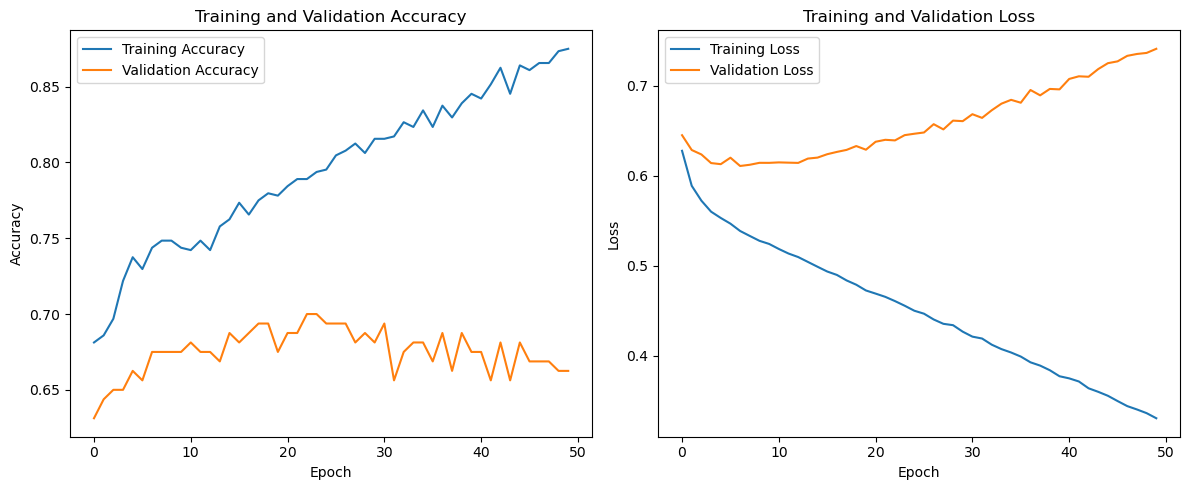

In [26]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

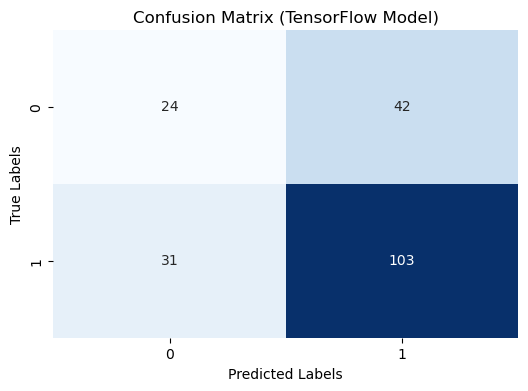

In [27]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (TensorFlow Model)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

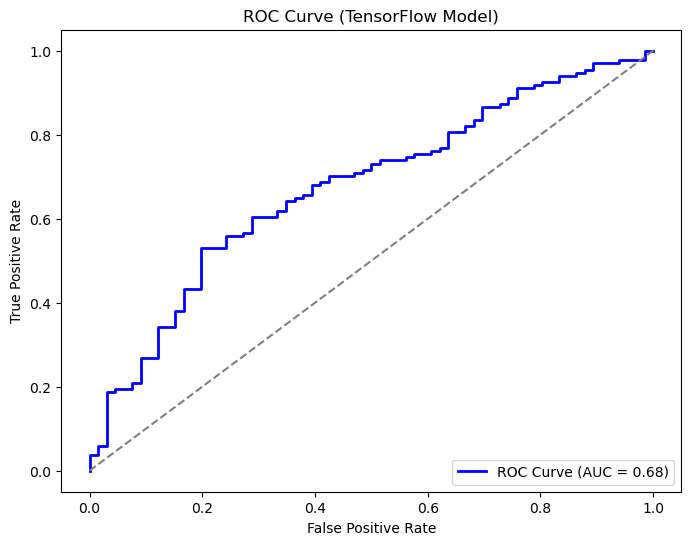

In [28]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve (TensorFlow Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

### **Cool things you can try doing if you want that won't be graded** <br>
1. Remove outliers to see if that improves the classification
2. Try out data visualization techniques that were not covered in the course
3. Implement feature selection and then try out MLP
4. See if you can implement transfer learning and hyperparameter tuning for your neural network model